In [2]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

45072


# 0. required packages for h5py

In [3]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [4]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH',
             'save_folder':r'D:\Pu_Temp\20201002_IgH_proB_iaa_dox+',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,23)

In [5]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 200

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.5, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
+ creating save folder: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction pro

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3314.62s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_03.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_03.dax  in 13.703s
-- removing hot pixels for channels:['750'] in 6.915s
-- illumination correction for channels: 750, in 1.571s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 70.915s
-- finish correction in 111.386s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ base attributes saved:['chrom_im

E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 243 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 159.360s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.018s.
+ loading unique from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ finish loading unique in 0.087s. 
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


++ base attributes loaded:[] in 0.736s.
- start select from 243 chromosomes with loss threshold=0.5
-- remove chr id 193, percentage of lost rounds:0.743.
-- remove chr id 9, percentage of lost rounds:0.722.
-- remove chr id 164, percentage of lost rounds:0.722.
-- remove chr id 21, percentage of lost rounds:0.694.
-- remove chr id 22, percentage of lost rounds:0.681.
-- remove chr id 18, percentage of lost rounds:0.646.
-- remove chr id 186, percentage of lost rounds:0.625.
-- remove chr id 113, percentage of lost rounds:0.569.
-- remove chr id 211, percentage of lost rounds:0.569.
-- remove chr id 191, percentage of lost rounds:0.562.
-- remove chr id 199, percentage of lost rounds:0.549.
-- remove chr id 229, percentage of lost rounds:0.549.
-- remove chr id 213, percentage of lost rounds:0.528.
-- remove chr id 188, percentage of lost rounds:0.521.
-- remove chr id 208, percentage of lost rounds:0.514.
-- remove chr id 217, percentage of lost rounds:0.514.
-- remove chr id 218, per

+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3265.93s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_04.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profil

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_05.dax  in 27.449s
-- removing hot pixels for channels:['488'] in 7.109s
-- illumination correction for channels: 488, in 1.573s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 36.437s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_05.hdf5
++ base attributes saved:['ref_im'] in 3.539s.
-- checking unique, region:[41 42] in 0.003s.
-- checking unique, region:[44 45] in 0.003s.
-- checking unique, region:[47 48] in 0.002s.
-- checking unique, region:[50 51] in 0.003s.
-- checking unique, region:[53 54] in 0.002s.
-- checking unique, region:[56 57] in 0.003s.
-- checking unique, region:[60 61] in 0.002s.
-- checking unique, region:[63 64] in 0.002s.
-- checking unique, region:[66 67] in 0.003s.
-- checking unique, region:[69 70] in 0.002s.
-- checking unique, region:[72 73] in 0.003s.
-- checking unique, reg

	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_06.dax: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5.
* create savefile: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.018s.
-- saving segmentation to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5
-- saving correction to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5
-- saving 750_illumin

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_06.dax  in 32.575s
-- removing hot pixels for channels:['750'] in 6.927s
-- illumination correction for channels: 750, in 1.539s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 70.699s
-- finish correction in 129.699s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5
++ base attributes saved:['chrom_im'] in 3.747s.
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_06.hdf5
++ base attributes loaded:[] in 1.183s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 237 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 thre

-- checking unique, region:[390 381] in 0.003s.
-- checking unique, region:[393 387] in 0.002s.
+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3345.44s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_07.dax
-- loading illumination correction profile f

-- checking unique, region:[347 334] in 0.003s.
-- checking unique, region:[353 344] in 0.003s.
-- checking unique, region:[359 350] in 0.002s.
-- checking unique, region:[365 356] in 0.002s.
-- checking unique, region:[371 362] in 0.003s.
-- checking unique, region:[377 368] in 0.002s.
-- checking unique, region:[384 374] in 0.003s.
-- checking unique, region:[390 381] in 0.003s.
-- checking unique, region:[393 387] in 0.003s.
+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365

-- illumination correction for channels: 488, in 1.585s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 33.191s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_09.hdf5
++ base attributes saved:['ref_im'] in 3.662s.
-- checking unique, region:[41 42] in 0.003s.
-- checking unique, region:[44 45] in 0.002s.
-- checking unique, region:[47 48] in 0.003s.
-- checking unique, region:[50 51] in 0.002s.
-- checking unique, region:[53 54] in 0.002s.
-- checking unique, region:[56 57] in 0.003s.
-- checking unique, region:[60 61] in 0.003s.
-- checking unique, region:[63 64] in 0.003s.
-- checking unique, region:[66 67] in 0.003s.
-- checking unique, region:[69 70] in 0.004s.
-- checking unique, region:[72 73] in 0.003s.
-- checking unique, region:[75 76] in 0.003s.
-- checking unique, region:[78 79] in 0.003s.
-- checking unique, region:[81 82] in 0.003s.
-- checking unique, region:[84 85] in 0.003s.
-- checking unique, re

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_10.dax: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5.
* create savefile: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.098s.
-- saving segmentation to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5
-- saving correction to file: D:\Pu_Temp\20201002_IgH_proB_i

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_10.dax  in 20.388s
-- removing hot pixels for channels:['750'] in 6.935s
-- illumination correction for channels: 750, in 1.587s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 75.764s
-- finish correction in 122.891s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5
++ base attributes saved:['chrom_im'] in 3.699s.
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_10.hdf5
++ base attributes loaded:[] in 1.192s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 239 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 thre

-- checking unique, region:[87 88] in 0.002s.
-- checking unique, region:[90 91] in 0.002s.
-- checking unique, region:[93 94] in 0.004s.
-- checking unique, region:[96 97] in 0.003s.
-- checking unique, region:[ 99 100] in 0.003s.
-- checking unique, region:[102 103] in 0.003s.
-- checking unique, region:[105 106] in 0.003s.
-- checking unique, region:[108 109] in 0.003s.
-- checking unique, region:[111 112] in 0.002s.
-- checking unique, region:[114 115] in 0.003s.
-- checking unique, region:[323 321] in 0.003s.
-- checking unique, region:[326 324] in 0.002s.
-- checking unique, region:[329 327] in 0.002s.
-- checking unique, region:[332 330] in 0.003s.
-- checking unique, region:[335 333] in 0.004s.
-- checking unique, region:[339 337] in 0.003s.
-- checking unique, region:[342 340] in 0.003s.
-- checking unique, region:[345 343] in 0.002s.
-- checking unique, region:[348 346] in 0.003s.
-- checking unique, region:[351 349] in 0.003s.
-- checking unique, region:[354 352] in 0.003s.


-- saving 488_illumination profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5.
-- saving 405_illumination profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5.
-- saving 750_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5.
-- saving 647_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5.
-- 647_chromatic_constants profile already exist in save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5, skip.
-- saving 750_647_bleed profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5.
-- saving unique to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_12.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in

++ base attributes loaded:[] in 0.728s.
- start select from 250 chromosomes with loss threshold=0.5
-- remove chr id 245, percentage of lost rounds:0.792.
-- remove chr id 70, percentage of lost rounds:0.785.
-- remove chr id 149, percentage of lost rounds:0.764.
-- remove chr id 218, percentage of lost rounds:0.757.
-- remove chr id 48, percentage of lost rounds:0.743.
-- remove chr id 101, percentage of lost rounds:0.743.
-- remove chr id 199, percentage of lost rounds:0.736.
-- remove chr id 121, percentage of lost rounds:0.729.
-- remove chr id 206, percentage of lost rounds:0.681.
-- remove chr id 100, percentage of lost rounds:0.674.
-- remove chr id 235, percentage of lost rounds:0.674.
-- remove chr id 119, percentage of lost rounds:0.667.
-- remove chr id 222, percentage of lost rounds:0.660.
-- remove chr id 162, percentage of lost rounds:0.653.
-- remove chr id 201, percentage of lost rounds:0.646.
-- remove chr id 231, percentage of lost rounds:0.611.
-- remove chr id 221, 

+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3326.98s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_13.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profil

-- checking unique, region:[359 350] in 0.005s.
-- checking unique, region:[365 356] in 0.003s.
-- checking unique, region:[371 362] in 0.003s.
-- checking unique, region:[377 368] in 0.003s.
-- checking unique, region:[384 374] in 0.003s.
-- checking unique, region:[390 381] in 0.004s.
-- checking unique, region:[393 387] in 0.003s.
+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 39

++ base attributes saved:['ref_im'] in 3.608s.
-- checking unique, region:[41 42] in 0.003s.
-- checking unique, region:[44 45] in 0.002s.
-- checking unique, region:[47 48] in 0.003s.
-- checking unique, region:[50 51] in 0.003s.
-- checking unique, region:[53 54] in 0.003s.
-- checking unique, region:[56 57] in 0.002s.
-- checking unique, region:[60 61] in 0.002s.
-- checking unique, region:[63 64] in 0.003s.
-- checking unique, region:[66 67] in 0.003s.
-- checking unique, region:[69 70] in 0.003s.
-- checking unique, region:[72 73] in 0.003s.
-- checking unique, region:[75 76] in 0.003s.
-- checking unique, region:[78 79] in 0.003s.
-- checking unique, region:[81 82] in 0.002s.
-- checking unique, region:[84 85] in 0.002s.
-- checking unique, region:[87 88] in 0.003s.
-- checking unique, region:[90 91] in 0.002s.
-- checking unique, region:[93 94] in 0.002s.
-- checking unique, region:[96 97] in 0.003s.
-- checking unique, region:[ 99 100] in 0.002s.
-- checking unique, region:[102

-- saving 750_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5.
-- saving 647_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5.
-- 647_chromatic_constants profile already exist in save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5, skip.
-- saving 750_647_bleed profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5.
-- saving unique to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.004s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_

-- remove chr id 235, percentage of lost rounds:0.785.
-- remove chr id 222, percentage of lost rounds:0.750.
-- remove chr id 203, percentage of lost rounds:0.729.
-- remove chr id 152, percentage of lost rounds:0.576.
-- remove chr id 140, percentage of lost rounds:0.562.
-- remove chr id 8, percentage of lost rounds:0.542.
-- remove chr id 167, percentage of lost rounds:0.542.
-- remove chr id 209, percentage of lost rounds:0.542.
-- remove chr id 157, percentage of lost rounds:0.535.
-- remove chr id 69, percentage of lost rounds:0.514.
-- remove chr id 75, percentage of lost rounds:0.507.
-- remove chr id 218, percentage of lost rounds:0.507.
-- 226 chromosomes are kept.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5
++ base attributes saved:['chrom_coords'] in 0.108s.
kept chromosomes: 226
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_

-- checking unique, region:[371 362] in 0.003s.
-- checking unique, region:[377 368] in 0.002s.
-- checking unique, region:[384 374] in 0.002s.
-- checking unique, region:[390 381] in 0.003s.
-- checking unique, region:[393 387] in 0.003s.
+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3416.95s.
-- choose chrom images from folder: \.
- correct the whole fov f

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_18.dax  in 13.305s
-- removing hot pixels for channels:['488'] in 7.012s
-- illumination correction for channels: 488, in 1.589s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 22.210s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5
++ base attributes saved:['ref_im'] in 3.632s.
-- checking unique, region:[41 42] in 0.004s.
-- checking unique, region:[44 45] in 0.003s.
-- checking unique, region:[47 48] in 0.003s.
-- checking unique, region:[50 51] in 0.003s.
-- checking unique, region:[53 54] in 0.003s.
-- checking unique, region:[56 57] in 0.003s.
-- checking unique, region:[60 61] in 0.003s.
-- checking unique, region:[63 64] in 0.003s.
-- checking unique, region:[66 67] in 0.003s.
-- checking unique, region:[69 70] in 0.003s.
-- checking unique, region:[72 73] in 0.003s.
-- checking unique, reg

	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_19.dax: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_19.hdf5.
* create savefile: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_19.hdf5
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_19.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.019s.
-- saving segmentation to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_19.hdf5
-- saving correction to file: D:\Pu_Temp\20201002_IgH_proB_i

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_19.dax  in 14.333s
-- removing hot pixels for channels:['750'] in 6.845s
-- illumination correction for channels: 750, in 1.549s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 74.163s
-- finish correction in 114.584s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_19.hdf5
++ base attributes saved:['chrom_im'] in 3.775s.
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_19.hdf5
++ base attributes loaded:[] in 1.213s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 317 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 thre

-- checking unique, region:[390 381] in 0.003s.
-- checking unique, region:[393 387] in 0.002s.
+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3556.43s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_20.dax
-- loading illumination correction profile f

-- checking unique, region:[84 85] in 0.003s.
-- checking unique, region:[87 88] in 0.003s.
-- checking unique, region:[90 91] in 0.003s.
-- checking unique, region:[93 94] in 0.003s.
-- checking unique, region:[96 97] in 0.004s.
-- checking unique, region:[ 99 100] in 0.003s.
-- checking unique, region:[102 103] in 0.003s.
-- checking unique, region:[105 106] in 0.003s.
-- checking unique, region:[108 109] in 0.003s.
-- checking unique, region:[111 112] in 0.002s.
-- checking unique, region:[114 115] in 0.003s.
-- checking unique, region:[323 321] in 0.003s.
-- checking unique, region:[326 324] in 0.003s.
-- checking unique, region:[329 327] in 0.003s.
-- checking unique, region:[332 330] in 0.002s.
-- checking unique, region:[335 333] in 0.003s.
-- checking unique, region:[339 337] in 0.003s.
-- checking unique, region:[342 340] in 0.002s.
-- checking unique, region:[345 343] in 0.002s.
-- checking unique, region:[348 346] in 0.003s.
-- checking unique, region:[351 349] in 0.002s.
--

-- saving 750_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_22.hdf5.
-- saving 647_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_22.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_22.hdf5.
-- 647_chromatic_constants profile already exist in save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_22.hdf5, skip.
-- saving 750_647_bleed profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_22.hdf5.
-- saving unique to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_22.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.021s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_22.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_

kept chromosomes: 299
5093 are found.


In [6]:
# select_hzxys close to the chromosome center
dist_th = 5000 # upper limit is 5000nm
intensity_th = 200
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 16 threads, in 21.079s
-- collapse all regions into 1d.


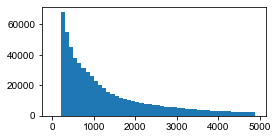

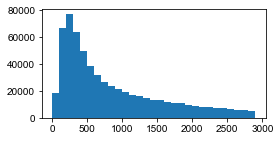

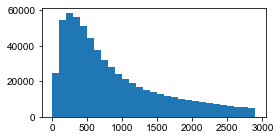

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 16 threads, in 29.391s
-- region kept: 0.7104
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 16 threads, in 20.698s
-- collapse all regions into 1d.


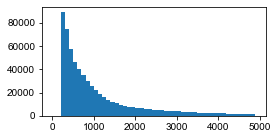

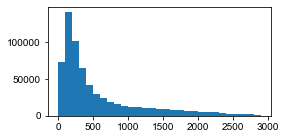

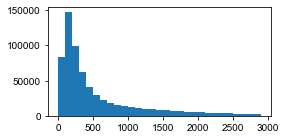

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 16 threads, in 29.673s
-- region kept: 0.8916
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 16 threads, in 21.156s
-- collapse all regions into 1d.


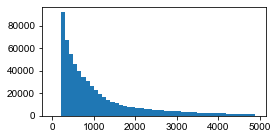

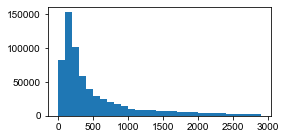

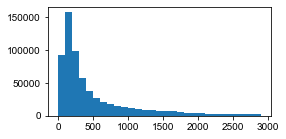

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 16 threads, in 29.671s
-- region kept: 0.9612
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 16 threads, in 20.652s
-- collapse all regions into 1d.


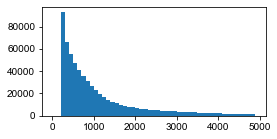

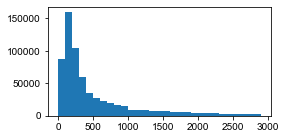

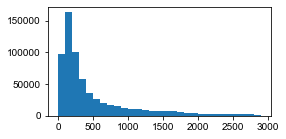

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 16 threads, in 29.671s
-- region kept: 0.9841
- iter:4
- generate reference metrics from picked chrs.
-- multiprocessing process references with 16 threads, in 21.280s
-- collapse all regions into 1d.


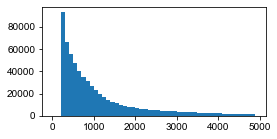

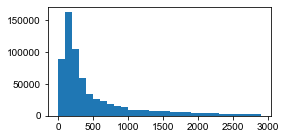

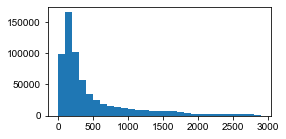

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 16 threads, in 29.648s
-- region kept: 0.9916
- iter:5
- generate reference metrics from picked chrs.
-- multiprocessing process references with 16 threads, in 20.713s
-- collapse all regions into 1d.


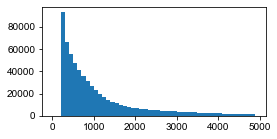

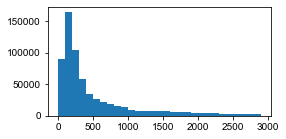

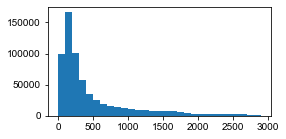

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 16 threads, in 29.927s
-- region kept: 0.9938
- iter:6
- generate reference metrics from picked chrs.
-- multiprocessing process references with 16 threads, in 21.462s
-- collapse all regions into 1d.


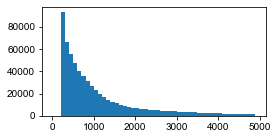

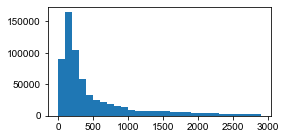

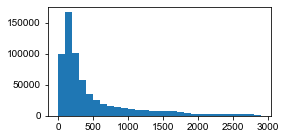

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 16 threads, in 31.026s
-- region kept: 0.9955


In [7]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 16
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

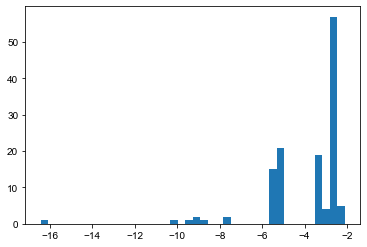

In [9]:
plt.figure()
plt.hist(np.log(sel_dna_scores_list[-1][1]), 40)
plt.show()

In [10]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = np.exp(-6)
int_th = 500
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    #_kept_hzxys[_scores < score_th] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

0.2025255446308078


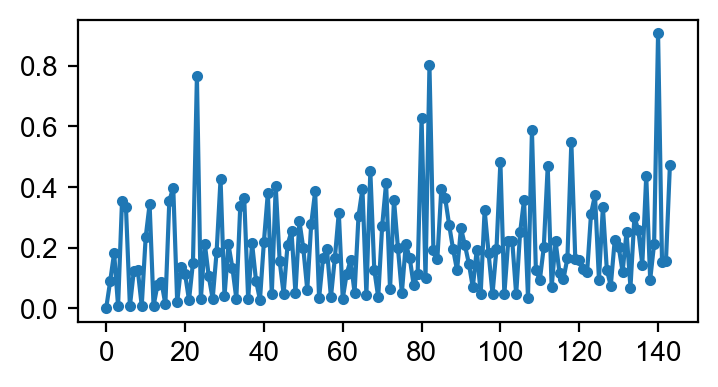

In [11]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [12]:
len(chrom_coords)

5093

In [13]:
kept_inds = np.where(loss_rates<0.5)[0]

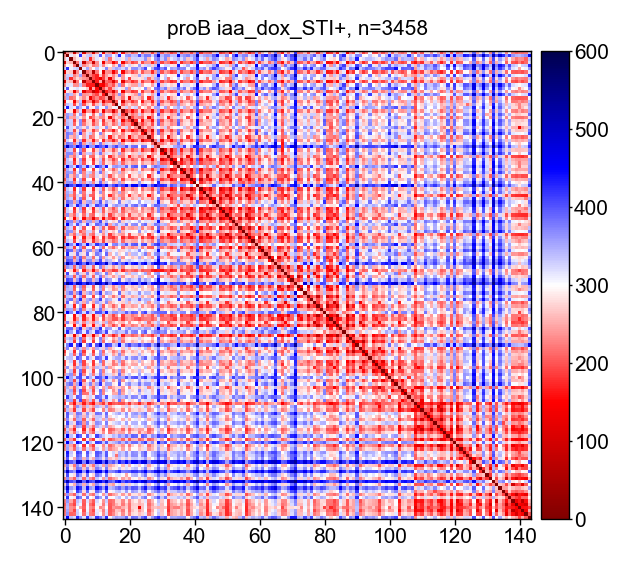

In [16]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB iaa_dox_STI+, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## visualize single example

<IPython.core.display.Javascript object>


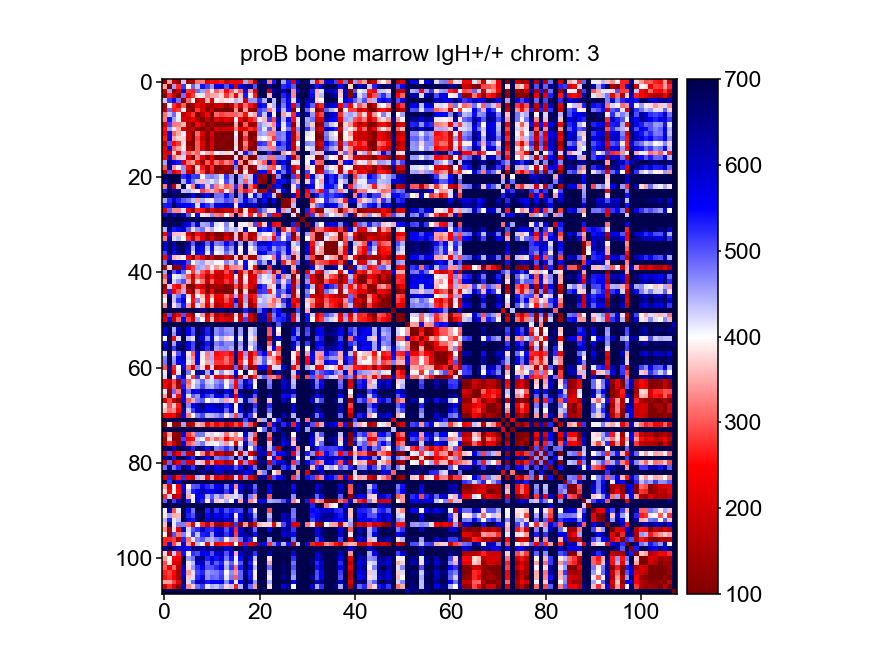

<IPython.core.display.Javascript object>


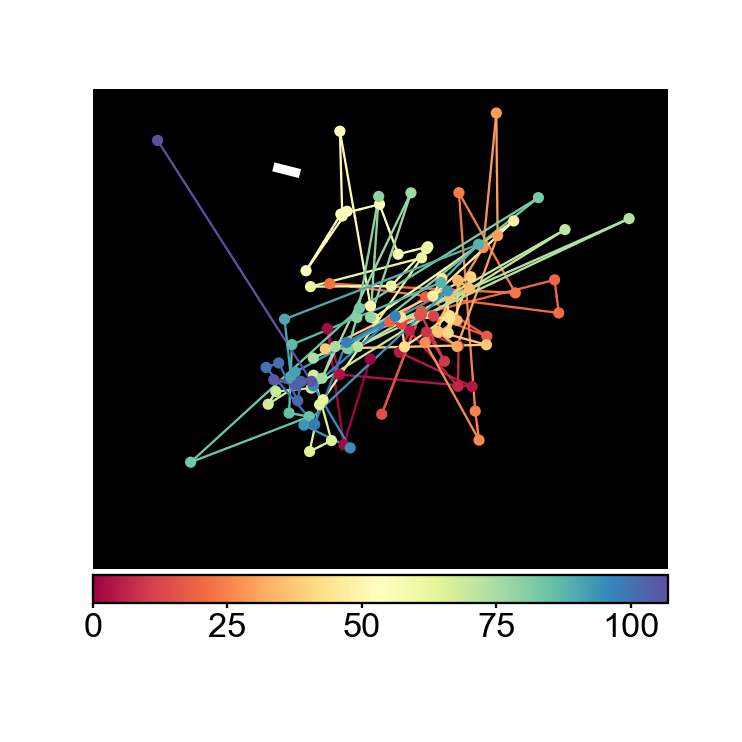

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x000002738340DE10>


In [20]:
%matplotlib notebook
chrom_id = 3

valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#distmap_list[chrom_id],
                                               distmap_list[chrom_id][valid_inds][:,valid_inds], 
                                               color_limits=[100,700],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB bone marrow IgH+/+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()



reload(figure_tools.image)
ax3d = figure_tools.image.chromosome_structure_3d_rendering(#final_dna_hzxys_list[chrom_id][:,1:], 
                                                     final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
                                                     marker_edge_line_width=0,
                                                     reference_bar_length=100, image_radius=400, 
                                                     line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

## save matrix

In [16]:
output_folder = r'\\10.245.74.158\Chromatin_NAS_6\20201031-processed_matrix'

np.save(os.path.join(output_folder, '20201002_proB_dox+'), distmap_list)